# Fine-Tuning LayoutLMv3 for Receipt Data Extraction

This notebook demonstrates a complete pipeline for fine-tuning the `microsoft/layoutlmv3-base` model on the CORD dataset for token classification. The goal is to extract structured information (like menu items, prices, and totals) from receipt images.

The process involves:
1.  **Setup & Configuration**: Installing dependencies and defining entity labels.
2.  **Data Preparation**: Loading and preprocessing the CORD dataset (images and JSON annotations).
3.  **Model Training**: Fine-tuning the LayoutLMv3 model on the prepared dataset.
4.  **Hyperparameter Tuning (Optional)**: Using Optuna to find the best training parameters.
5.  **Final Training & Evaluation**: Training the model with the optimal hyperparameters.
6.  **Inference**: Using the fine-tuned model to extract entities from a new, unseen receipt image.

## 1. Setup and Dependencies

First, we install and import all the necessary libraries. This includes `transformers`, `datasets`, `torch`, and `pytesseract` for OCR.

In [ ]:
!pip install pytesseract transformers torch Pillow datasets seqeval optuna

In [1]:
# Basic imports for OS, data handling, and image processing
import os
import json
import re
import torch
import pandas as pd
import numpy as np
import pytesseract
import joblib
import optuna
from PIL import Image
from collections import Counter, defaultdict

# Hugging Face libraries for datasets and models
from datasets import Dataset, DatasetDict
from transformers import (
    LayoutLMv3Processor, 
    LayoutLMv3ForTokenClassification,
    TrainingArguments,
    Trainer
)

# Metrics for evaluation
from seqeval.metrics import f1_score, classification_report

W0726 11:04:52.522000 18908 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


## 2. Data Preparation

In this section, we define the schema for our receipt data, load the CORD dataset, and preprocess it into a format suitable for training LayoutLMv3.

In [3]:
# Step 2.1: Define Label Schema
# This defines all possible entity categories from the CORD dataset.
categories = [
    "menu.cnt", "menu.discountprice", "menu.etc", "menu.itemsubtotal", "menu.nm",
    "menu.num", "menu.price", "menu.sub_cnt", "menu.sub_etc", "menu.sub_nm",
    "menu.sub_price", "menu.sub_unitprice", "menu.unitprice", "menu.vatyn",
    "sub_total.discount_price", "sub_total.etc", "sub_total.othersvc_price",
    "sub_total.service_price", "sub_total.subtotal_price", "sub_total.tax_price",
    "total.cashprice", "total.changeprice", "total.creditcardprice",
    "total.emoneyprice", "total.menuqty_cnt", "total.menutype_cnt",
    "total.total_etc", "total.total_price", "void_menu.nm", "void_menu.price"
]

# Build BIO (Beginning, Inside, Outside) tag schema and create label-to-ID mappings.
label_list = [f"B-{c}" for c in categories] + [f"I-{c}" for c in categories]
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}
num_labels = len(label_list) # Store the total number of labels for the model

# Step 2.2: Initialize the LayoutLMv3 Processor
# The processor handles tokenization, image processing, and alignment of text with layout data.
# `apply_ocr=False` is crucial because we are providing our own OCR'd text and boxes from the dataset.
processor = LayoutLMv3Processor.from_pretrained(
    "microsoft/layoutlmv3-base",
    apply_ocr=False
)

C:\Users\praag\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Step 2.3: Define Functions to Parse and Load the CORD Dataset

def parse_cord_file(image_path: str, json_path: str):
    """Parses a single image and its corresponding JSON annotation file."""
    data = json.load(open(json_path, encoding="utf-8"))
    img = Image.open(image_path).convert("RGB")
    width, height = img.size

    words = []
    boxes = []
    tags = []

    # Iterate over each annotated line in the JSON file
    for line in data.get("valid_line", []):
        cat = line.get("category", "")
        for idx, word_info in enumerate(line.get("words", [])):
            text = word_info.get("text", "")
            quad = word_info.get("quad", {})
            # Calculate bounding box coordinates [xmin, ymin, xmax, ymax]
            xmin = min(quad.get("x1", 0), quad.get("x4", 0))
            ymin = min(quad.get("y1", 0), quad.get("y2", 0))
            xmax = max(quad.get("x2", 0), quad.get("x3", 0))
            ymax = max(quad.get("y3", 0), quad.get("y4", 0))

            # Normalize bounding box coordinates to a 0-1000 scale
            norm_box = [
                int(1000 * xmin / width),
                int(1000 * ymin / height),
                int(1000 * xmax / width),
                int(1000 * ymax / height),
            ]
            norm_box = [min(max(x, 0), 1000) for x in norm_box]

            words.append(text)
            boxes.append(norm_box)

            # Assign BIO tags: 'B-' for the first word in an entity, 'I-' for subsequent words
            prefix = "B-" if idx == 0 else "I-"
            label = f"{prefix}{cat}"
            tags.append(label2id.get(label, -100))  # Use -100 to ignore unknown labels during training

    # Use the processor to tokenize words and align everything
    encoding = processor(
        images=img,
        text=words,
        boxes=boxes,
        word_labels=tags,
        truncation=True,
        return_tensors="pt"
    )

    return {k: v.squeeze() for k, v in encoding.items()} # Remove the batch dimension

def build_dataset(split_dir: str) -> Dataset:
    """Builds a Hugging Face Dataset from a directory split (e.g., 'train', 'dev')."""
    examples = []
    img_dir = os.path.join(split_dir, "image")
    json_dir = os.path.join(split_dir, "json")

    for fname in os.listdir(json_dir):
        if not fname.lower().endswith(".json"): continue
        json_path = os.path.join(json_dir, fname)
        base = os.path.splitext(fname)[0]

        # The dataset contains both .png and .jpg files, so we check for both
        image_path = None
        for ext in (".png", ".jpg"):
            candidate = os.path.join(img_dir, base + ext)
            if os.path.exists(candidate):
                image_path = candidate
                break

        if image_path is None:
            print(f"⚠️ Skipping {fname} — image not found.")
            continue

        examples.append({"image_path": image_path, "json_path": json_path})

    return Dataset.from_list(examples)

def load_cord_dataset(base_path: str) -> DatasetDict:
    """Combines train, validation, and test splits into a single DatasetDict."""
    return DatasetDict({
        "train": build_dataset(os.path.join(base_path, "train")),
        "validation": build_dataset(os.path.join(base_path, "dev")),
        "test": build_dataset(os.path.join(base_path, "test")),
    })

In [7]:
# Step 2.4: Load and Process the Dataset
# NOTE: This cell failed previously due to a FileNotFoundError. 
# Ensure the path points to the correct root directory of the CORD dataset.

def preprocess(example):
    # This helper function calls our main parsing function for each example
    return parse_cord_file(example["image_path"], example["json_path"])

# Replace this with the actual path to your CORD dataset folder
dataset_path = "C:\\Users\\praag\\Desktop\\scrapiq\\CORD-20250714T102918Z-1-001\\CORD"

try:
    # Load the raw dataset (paths to images and jsons)
    raw_dataset = load_cord_dataset(dataset_path)

    # Apply the preprocessing function to tokenize and encode the entire dataset
    encoded_dataset = raw_dataset.map(
        preprocess, 
        remove_columns=["image_path", "json_path"]
    )
    print("Dataset successfully loaded and encoded.")
    print(encoded_dataset)
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please verify that the `dataset_path` variable is set correctly.")
    # Create a placeholder to avoid subsequent NameErrors
    encoded_dataset = None 

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset successfully loaded and encoded.
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'],
        num_rows: 651
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'],
        num_rows: 99
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'],
        num_rows: 100
    })
})


## 3. Model Training (Baseline)

With the data prepared, we can now define our model, set up training arguments, and run an initial training loop to establish a baseline performance.

In [9]:
# Step 3.1: Initialize the Model
# We load the pre-trained LayoutLMv3 model and configure it for our specific token classification task.
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels, # The number of labels we defined earlier
    id2label=id2label,
    label2id=label2id,
)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Step 3.2: Define Training Arguments
# These arguments control various aspects of the training process, like batch size, learning rate, and saving strategy.
args = TrainingArguments(
    output_dir="outputs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=20,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir="logs",
    save_total_limit=2,
    report_to="none",
    load_best_model_at_end=True,        
    metric_for_best_model="eval_f1", # Use F1-score to determine the best model checkpoint
)

In [13]:
# Step 3.3: Define Evaluation Metrics
# This function calculates metrics like F1-score and a detailed classification report during evaluation.
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    # Align predictions and labels, ignoring the -100 tokens
    true_labels = []
    true_preds  = []
    for pred_seq, label_seq in zip(preds, labels):
        valid_idxs = label_seq != -100
        true_labels.append([id2label[l] for l in label_seq[valid_idxs]])
        true_preds.append ([id2label[p] for p, v in zip(pred_seq, valid_idxs) if v])

    # Calculate F1 score and the full classification report
    f1 = f1_score(true_labels, true_preds)
    report = classification_report(true_labels, true_preds, output_dict=True, zero_division="0")

    metrics = {"f1": f1}
    # Flatten the report to be compatible with the Trainer logs
    for main_key, sub_dict in report.items():
        if isinstance(sub_dict, dict):
            for sub_key, value in sub_dict.items():
                metrics[f"{main_key}_{sub_key}"] = value
    return metrics

In [15]:
# Step 3.4: Define Custom Data Collator
# This function is responsible for creating batches of data. It pads sequences to the same length.
def collate_fn(examples):
    # Stack the pixel_values (image data) into a single tensor
    pixel_values = torch.stack([torch.tensor(e["pixel_values"]) for e in examples])
    
    # Collect other features into lists
    input_ids      = [e["input_ids"]      for e in examples]
    attention_mask = [e["attention_mask"] for e in examples]
    bbox           = [e["bbox"]           for e in examples]
    labels         = [e["labels"]         for e in examples]
    
    # Use the tokenizer's pad method to handle padding for text-based features
    batch_tokens = processor.tokenizer.pad(
        {
            "input_ids": input_ids, "attention_mask": attention_mask,
            "bbox": bbox, "labels": labels
        },
        padding="longest", return_tensors="pt"
    )
    
    # Merge the pixel_values back into the final batch dictionary
    batch = {"pixel_values": pixel_values, **batch_tokens}
    return batch

In [17]:
# Step 3.5: Initialize and Run the Trainer
# This cell previously failed because `encoded_dataset` was not defined.
# It should now run correctly if the data preparation step was successful.

if encoded_dataset is not None:
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=encoded_dataset["train"],       
        eval_dataset=encoded_dataset["validation"], 
        tokenizer=processor.tokenizer, # Pass the tokenizer for padding
        data_collator=collate_fn,                    
        compute_metrics=compute_metrics,             
    )

    # Start the training process
    trainer.train()
else:
    print("Skipping training because the dataset could not be loaded.")

C:\Users\praag\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a LayoutLMv3TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\Users\praag\anaconda3\Lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## 4. Hyperparameter Tuning with Optuna (Optional)

This section demonstrates how to use Optuna to search for the best hyperparameters (like learning rate, batch size, and number of epochs) to improve model performance.

In [19]:
# Step 4.1: Define the Objective Function for Optuna

def model_init():
    """Initializes a new model for each trial to ensure no weight leakage."""
    return LayoutLMv3ForTokenClassification.from_pretrained(
        "microsoft/layoutlmv3-base",
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

def objective(trial):
    """This function defines one Optuna trial, which trains and evaluates a model with a given set of hyperparameters."""
    # Suggest hyperparameters for the trial
    args = TrainingArguments(
        output_dir=f"outputs/optuna/{trial.number}",
        evaluation_strategy="epoch",
        save_strategy="no", # No need to save checkpoints during HPO
        learning_rate=trial.suggest_float("lr", 1e-5, 1e-4, log=True),
        per_device_train_batch_size=trial.suggest_categorical("batch", [2, 4]),
        num_train_epochs=trial.suggest_int("epochs", 3, 8),
        logging_dir=f"logs/optuna/{trial.number}",
        report_to=[],
    )

    trainer = Trainer(
        model_init=model_init, # A function that returns a new model
        args=args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=processor.tokenizer,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    trainer.train()
    metrics = trainer.evaluate()
    return metrics["eval_f1"]  # The objective is to maximize the F1 score


In [ ]:
# Step 4.2: Run the Hyperparameter Search
# This cell was previously interrupted. Re-running it will start a new search.

if encoded_dataset is not None:
    # Create a study. 'direction="maximize"' means Optuna will try to find params that maximize the objective's return value (F1 score).
    study = optuna.create_study(direction="maximize")
    
    # Start the optimization process for a set number of trials
    study.optimize(objective, n_trials=3, timeout=7200) # Reduced to 3 trials for a quick example
    
    # Save the study results for later use
    joblib.dump(study, "optuna_study.pkl")
    
    print("--- Optuna Search Complete ---")
    print("Best F1 score:", study.best_value)
    print("Best params:", study.best_params)
else:
    print("Skipping hyperparameter tuning because the dataset could not be loaded.")

## 5. Final Model Training

After finding the optimal hyperparameters, we retrain the model one last time on the full training set using these best parameters and save the final artifact.

### Load Best Hyperparameters
This cell loads the best parameters found by the Optuna study and defines the final training arguments.

In [23]:
# Step 5.1: Load the Best Hyperparameters and Define Final Training Arguments

try:
    # Load the results from the saved Optuna study
    study = joblib.load("optuna_study.pkl")
    best_params = study.best_params
    print(f"Loaded best parameters from Optuna study: {best_params}")

    # Create the final training arguments using the best hyperparams
    best_args = TrainingArguments(
        output_dir="final_model_outputs",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=best_params['lr'],
        per_device_train_batch_size=best_params['batch'],
        per_device_eval_batch_size=best_params['batch'], # Use the same batch size for eval
        num_train_epochs=best_params['epochs'],
        logging_dir="final_model_logs",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        save_total_limit=1, # Only keep the very best checkpoint
        report_to=[],
    )
except FileNotFoundError:
    print("Could not find 'optuna_study.pkl'. Using baseline training arguments instead.")
    best_args = args # Fallback to the initial arguments if Optuna wasn't run

Loaded best parameters from Optuna study: {'lr': 2.2431387959905245e-05, 'batch': 4, 'epochs': 8}


### Run Final Training
This cell initializes a new model and trains it using the best hyperparameters found.

In [25]:
# Step 5.2: Initialize and Run the Final Trainer

# Initialize a fresh model to train from scratch with the best parameters
final_model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

if encoded_dataset is not None:
    final_trainer = Trainer(
        model=final_model,
        args=best_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=processor.tokenizer,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # Train the final model
    final_trainer.train()

    # Evaluate on the test set
    test_metrics = final_trainer.evaluate(encoded_dataset["test"])
    print("--- Final Test Set Evaluation ---")
    print(test_metrics)

    # Save the final model and processor
    final_model_path = "final_layoutlmv3_model"
    final_trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)
    print(f"Final model saved to {final_model_path}")
else:
    print("Skipping final training because the dataset could not be loaded.")

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## 6. Inference

This section shows how to use the final, fine-tuned model to extract information from a new receipt image that was not in the training set.

### Load Fine-Tuned Model for Inference
This cell loads the final model and processor that were saved after training.

In [27]:
# Step 6.1: Load the Fine-Tuned Model and Processor

final_model_path = "final_layoutlmv3_model"

try:
    inference_processor = LayoutLMv3Processor.from_pretrained(final_model_path, apply_ocr=False)
    inference_model = LayoutLMv3ForTokenClassification.from_pretrained(final_model_path)
    inference_model.eval() # Set the model to evaluation mode
    print(f"Successfully loaded model from {final_model_path}")
except OSError:
    print(f"Error: Model not found at {final_model_path}. Please run the final training step first.")
    inference_processor = None
    inference_model = None

Successfully loaded model from final_layoutlmv3_model


### Define the Inference Pipeline
This function takes an image path, performs OCR, runs the model prediction, and returns a DataFrame of words and their predicted labels.

In [58]:
# Step 6.2: Define the Inference Pipeline

def infer_from_image(image_path: str):
    """Performs OCR and model prediction on a single image file."""
    if inference_model is None or inference_processor is None:
        print("Inference model is not loaded. Cannot proceed.")
        return pd.DataFrame()

    # 1. OCR the image to get words and boxes
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    words, boxes = [], []
    for i, txt in enumerate(data["text"]):
        t = txt.strip()
        if not t or not re.search(r"\w", t): continue
        x, y, wi, hi = (data["left"][i], data["top"][i], data["width"][i], data["height"][i])
        norm_box = [
            int(1000 * x / w), int(1000 * y / h),
            int(1000 * (x+wi) / w), int(1000 * (y+hi) / h)
        ]
        boxes.append([min(max(v,0),1000) for v in norm_box])
        words.append(t)

    # 2. Encode the OCR data
    encoding = inference_processor(
        img, text=words, boxes=boxes, return_tensors="pt", 
        truncation=True, padding="max_length", max_length=512
    )
    word_ids = encoding.word_ids(batch_index=0)

    # 3. Predict with the model
    with torch.no_grad():
        logits = inference_model(**encoding).logits.squeeze(0)
    preds = logits.argmax(-1).tolist()

    # 4. Map token predictions back to word-level predictions
    word_pred = {}
    for idx, wid in enumerate(word_ids):
        if wid is not None and wid not in word_pred:
            word_pred[wid] = preds[idx]

    # 5. Create a result DataFrame
    rows = []
    for i, w in enumerate(words):
        label_id = word_pred.get(i, -100)
        label = id2label.get(label_id, "O") # Use .get for safety
        rows.append({"word": w, "label": label})

    return pd.DataFrame(rows)

df = infer_from_image("C:\\Users\\praag\\Downloads\\rr.png")
# only show predicted entities (non-O)
display(df[df["label"] != "O"])

C:\Users\praag\anaconda3\Lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


,word,label
0,RECEIPT,B-total.cashprice
1,East,B-menu.nm
2,Repair,I-menu.nm
3,Inc.,B-menu.price
4,1912,B-menu.nm
...,...,...
110,payable,I-total.changeprice
111,to:,I-total.changeprice
112,East,I-total.changeprice
113,Repair,I-total.changeprice


### Define Post-Processing Functions
These functions take the raw model output (words and labels) and aggregate them into a more structured and readable format.

In [31]:
# Step 6.3: Define Post-Processing Functions

def aggregate_entities(df):
    """Groups tokens into coherent entities based on their BIO labels."""
    df_filtered = df[df.label != "O"].copy()
    if df_filtered.empty:
        return []
    
    # Extract the base entity type from the BIO tag (e.g., 'B-menu.nm' -> 'menu.nm')
    df_filtered["entity"] = df_filtered["label"].str.split(pat="-", n=1).str[1]

    # Group consecutive words of the same entity type
    records = []
    for _, group in df_filtered.groupby((df_filtered.entity != df_filtered.entity.shift()).cumsum()):
        entity_type = group.entity.iloc[0]
        text = " ".join(group.word.tolist())
        records.append({"entity": entity_type, "text": text})
    
    return records

def format_receipt_output(records):
    """Pivots the extracted records into a human-readable table and a structured dictionary."""
    if not records:
        print("No entities found to format.")
        return {}

    # Build a dictionary, allowing for multiple values per entity
    receipt_dict = defaultdict(list)
    for rec in records:
        receipt_dict[rec["entity"]].append(rec["text"])
    
    # For entities that only appear once, convert them from a list to a single value
    final_dict = {k: v[0] if len(v) == 1 else v for k, v in receipt_dict.items()}
    
    # Display as a styled Pandas DataFrame
    df = pd.DataFrame(records)
    pivot = (
        df.assign(item_number=lambda d: d.groupby("entity").cumcount())
        .pivot(index="item_number", columns="entity", values="text")
        .fillna("").reset_index(drop=True)
    )
    display(pivot.style.set_caption("🧾 Extracted Receipt Data"))
    
    return final_dict

### (Optional) Aggregate and Display Raw Predictions
This cell aggregates the raw word predictions into entities for a quick inspection.

In [60]:
records = aggregate_entities(df)
for r in records:
    print(f"{r['entity']:20} → {r['text']}")

total.cashprice      → RECEIPT
menu.nm              → East Repair
menu.price           → Inc.
menu.nm              → 1912 Harvest Lane New York, NY
menu.num             → 12210
total.menuqty_cnt    → BILLTO SHIP TO RECEIPT
total.creditcardprice → us-001
menu.num             → John
menu.sub_nm          → Smith
menu.num             → John
menu.sub_nm          → Smith
total.menuqty_cnt    → RECEIPT
total.changeprice    → DATE
menu.num             → 11/02/2019
menu.cnt             → 2
menu.nm              → Court Square
menu.num             → 3787
menu.nm              → Pineview Drive
total.menuqty_cnt    → Post
menu.nm              → New York, NY
menu.num             → 12210
menu.nm              → Cambridge, MA 12210
menu.sub_nm          → oy
menu.num             → 2312/2019
total.changeprice    → DUE DATE 26/02/2019
menu.nm              → FEI II IO IOI IOI OI OO
menu.unitprice       → IO IOI
menu.nm              → IO IOI IOI III
menu.sub_nm          → II
menu.sub_price       → TOS IOS IO

### Format and Display Final Output
This cell formats the aggregated entities into a clean table and a structured dictionary.

In [64]:
receipt_struct = format_receipt_output(records)
print("\n📂 Structured Receipt Dictionary:")
import json; print(json.dumps(receipt_struct, indent=2))

entity,menu.cnt,menu.nm,menu.num,menu.price,menu.sub_nm,menu.sub_price,menu.unitprice,sub_total.subtotal_price,sub_total.tax_price,total.cashprice,total.changeprice,total.creditcardprice,total.emoneyprice,total.menuqty_cnt,total.total_price
0,2,East Repair,12210,Inc.,Smith,TOS IOS IOS IOS IK,IO IOI,‘Subtotal 145.00,PRICE,RECEIPT,DATE,us-001,within 15,BILLTO SHIP TO RECEIPT,TOTAL $154.06
1,1,"1912 Harvest Lane New York, NY",John,100.00 100.00,Smith,AMOUNT,15.00,,Sales Tax 6.25% 9.08,,DUE DATE 26/02/2019,make checks,,RECEIPT,
2,2,Court Square,John,30.00,oy,,5.00,,,,Swit,,,Post,
3,3,Pineview Drive,11/02/2019,15.00,II,,,,,,Payment is due,,,ay DESCRIPTION UNIT,
4,,"New York, NY",3787,,,,,,,,days. Jou,,,TERMS CONDITIONS oh h,
5,,"Cambridge, MA 12210",12210,,,,,,,,payable to: East Repair Inc.,,,Please,
6,,FEI II IO IOI IOI OI OO,2312/2019,,,,,,,,,,,,
7,,IO IOI IOI III,,,,,,,,,,,,,
8,,Front and rear brake cables,,,,,,,,,,,,,
9,,New set of pedal arms,,,,,,,,,,,,,



📂 Structured Receipt Dictionary:
{
  "total.cashprice": "RECEIPT",
  "menu.nm": [
    "East Repair",
    "1912 Harvest Lane New York, NY",
    "Court Square",
    "Pineview Drive",
    "New York, NY",
    "Cambridge, MA 12210",
    "FEI II IO IOI IOI OI OO",
    "IO IOI IOI III",
    "Front and rear brake cables",
    "New set of pedal arms",
    "Labor hrs"
  ],
  "menu.price": [
    "Inc.",
    "100.00 100.00",
    "30.00",
    "15.00"
  ],
  "menu.num": [
    "12210",
    "John",
    "John",
    "11/02/2019",
    "3787",
    "12210",
    "2312/2019"
  ],
  "total.menuqty_cnt": [
    "BILLTO SHIP TO RECEIPT",
    "RECEIPT",
    "Post",
    "ay DESCRIPTION UNIT",
    "TERMS CONDITIONS oh h",
    "Please"
  ],
  "total.creditcardprice": [
    "us-001",
    "make checks"
  ],
  "menu.sub_nm": [
    "Smith",
    "Smith",
    "oy",
    "II"
  ],
  "total.changeprice": [
    "DATE",
    "DUE DATE 26/02/2019",
    "Swit",
    "Payment is due",
    "days. Jou",
    "payable to: East Repair 

In [70]:
image_path="C:\\Users\\praag\\Downloads\\rr.png"

### (Optional) Custom OCR Line Extraction
This function provides a more advanced way to group OCR tokens into lines, which can be useful for debugging or alternative preprocessing.

In [78]:
import cv2
import pytesseract

def extract_lines_custom(
    image_path, 
    y_tol=10,         # max pixel vertical deviation to stay on same line
    conf_thresh=50,   # drop tokens < this confidence
):
    # 1) OCR → raw tokens
    img = cv2.imread("C:\\Users\\praag\\Downloads\\rr.png")
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    tokens = []
    for i, txt in enumerate(data['text']):
        txt = txt.strip()
        conf = int(data['conf'][i])
        if not txt or conf < conf_thresh:
            continue
        x, y, w, h = (data[k][i] for k in ('left','top','width','height'))
        cy = y + h/2
        tokens.append({
            'text': txt,
            'x': x, 'y': y, 'w': w, 'h': h, 'cy': cy,
            'conf': conf
        })

    # 2) Sort tokens top→down, then left→right
    tokens.sort(key=lambda t: (t['cy'], t['x']))

    # 3) Group into lines by y_tol
    lines = []
    if tokens:
        current = {
            'cy_sum': tokens[0]['cy'], 
            'count': 1, 
            'tokens': [tokens[0]]
        }
        for t in tokens[1:]:
            # compute current running line center
            cur_center = current['cy_sum'] / current['count']
            if abs(t['cy'] - cur_center) <= y_tol:
                # same line
                current['tokens'].append(t)
                current['cy_sum'] += t['cy']
                current['count'] += 1
            else:
                # flush old line
                lines.append(current['tokens'])
                # start new line
                current = {
                    'cy_sum': t['cy'], 
                    'count': 1, 
                    'tokens': [t]
                }
        lines.append(current['tokens'])

    # 4) Build final text+bbox per line
    result = []
    for idx, toks in enumerate(lines, start=1):
        # sort left→right
        toks.sort(key=lambda t: t['x'])
        line_text = ' '.join(t['text'] for t in toks)
        # bounding‑box union
        x0 = min(t['x'] for t in toks)
        y0 = min(t['y'] for t in toks)
        x1 = max(t['x']+t['w'] for t in toks)
        y1 = max(t['y']+t['h'] for t in toks)
        result.append({
            'line_id': idx,
            'text': line_text,
            'bbox': (x0, y0, x1-x0, y1-y0),
            'avg_conf': sum(t['conf'] for t in toks)/len(toks)
        })

    return result

# === example call ===
lines = extract_lines_custom(
    image_path,
    y_tol=8,       # you may need to tweak this per image resolution
    conf_thresh=30 # drop very low‑confidence tokens
)

for L in lines:
    print(f"Line {L['line_id']:2d} [{L['avg_conf']:.0f}%]: {L['text']}")


Line  1 [96%]: RECEIPT
Line  2 [94%]: East Repair Inc.
Line  3 [90%]: 1912 Harvest Lane
Line  4 [94%]: New York, NY 12210
Line  5 [78%]: BILLTO RECEIPT # us-001
Line  6 [90%]: John Smith John Smith RECEIPT DATE 11102/2019
Line  7 [83%]: 2 Court Square 3787 Pineview Drive
Line  8 [88%]: New York, NY 12210 Cambridge, MA 12210 post 2312/2019
Line  9 [84%]: DUE DATE
Line 10 [44%]: FIO II IOI IO IO IOI IO IOI IOI III II IOS IOS IOS IOS IK
Line 11 [89%]: ay DESCRIPTION UNIT PRICE AMOUNT
Line 12 [83%]: 1 Front and rear brake cables 100.00 100.00
Line 13 [81%]: 2 New set of pedal arms 16.00 30.00
Line 14 [71%]: 3 Labor 5.00 15.00
Line 15 [75%]: ‘Subtotal 145.00
Line 16 [89%]: Sales Tax 6.25% 9.08
Line 17 [94%]: TOTAL $154.06
Line 18 [54%]: Swit
Line 19 [93%]: TERMS & CONDITIONS
Line 20 [92%]: Payment is due within 15 days.
Line 21 [82%]: oh
Line 22 [90%]: Jou Please make checks payable to: East Repair Inc.


In [80]:
#v imp code for ocr 


processor = LayoutLMv3Processor.from_pretrained("final_layoutlmv3_model", apply_ocr=False)
model     = LayoutLMv3ForTokenClassification.from_pretrained("final_layoutlmv3_model")
model.eval()


import pytesseract, re, torch, pandas as pd
from PIL import Image

def infer_from_image(image_path):
    # 1. OCR + normalize boxes
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    words, boxes = [], []
    for i, txt in enumerate(data["text"]):
        t = txt.strip()
        if not t or not re.search(r"\w", t): continue
        x, y, wi, hi = (data["left"][i], data["top"][i],
                        data["width"][i], data["height"][i])
        norm = [int(1000 * x / w), int(1000 * y / h),
                int(1000 * (x+wi) / w), int(1000 * (y+hi) / h)]
        boxes.append([min(max(v,0),1000) for v in norm])
        words.append(t)

    # 2. Encode *with* word_ids tracking
    encoding = processor(
        img,
        text=words,
        boxes=boxes,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    # HuggingFace API to get the alignment of tokens → words
    word_ids = encoding.word_ids(batch_index=0)

    # 3. Predict
    with torch.no_grad():
        logits = model(
            input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"],
            bbox=encoding["bbox"],
            token_type_ids=encoding.get("token_type_ids")  # add this if your processor provides it
        ).logits.squeeze(0)
  # [seq_len, num_labels]
    preds = logits.argmax(-1).tolist()               # [seq_len]

    # 4. Map subword preds → word preds (first subword only)
    word_pred: dict[int,int] = {}
    for idx, wid in enumerate(word_ids):
        if wid is None: continue
        if wid not in word_pred:  # take first subtoken of each word
            word_pred[wid] = preds[idx]

    # 5. Build final table of (word, label)
    rows = []
    for i, w in enumerate(words):
        lid = word_pred.get(i, -100)
        lab = id2label[lid] if lid != -100 else "O"
        rows.append({"word": w, "label": lab})

    return pd.DataFrame(rows)

# --- Test it on your sample image ---
df = infer_from_image("C:\\Users\\praag\\Downloads\\rr.png")
# only show predicted entities (non-O)
display(df[df["label"] != "O"])


C:\Users\praag\anaconda3\Lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


,word,label
0,RECEIPT,I-total.changeprice
1,East,B-menu.nm
2,Repair,I-menu.nm
3,Inc.,I-menu.nm
4,1912,B-menu.cnt
...,...,...
110,payable,I-total.changeprice
111,to:,I-total.changeprice
112,East,B-menu.nm
113,Repair,I-total.changeprice


In [46]:
df = infer_from_image("C:\\users\\praag\\Desktop\\scrapiq\\CORD-20250714T102918Z-1-001\\CORD\\test\\image\\receipt_00013.png")
print(df.head())


C:\Users\praag\anaconda3\Lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Empty DataFrame
Columns: []
Index: []


In [82]:
import cv2
import pytesseract

def extract_lines_custom(
    image_path, 
    y_tol=10,         # max pixel vertical deviation to stay on same line
    conf_thresh=50,   # drop tokens < this confidence
):
    # 1) OCR → raw tokens
    img = cv2.imread(image_path)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    tokens = []
    for i, txt in enumerate(data['text']):
        txt = txt.strip()
        conf = int(data['conf'][i])
        if not txt or conf < conf_thresh:
            continue
        x, y, w, h = (data[k][i] for k in ('left','top','width','height'))
        cy = y + h/2
        tokens.append({
            'text': txt,
            'x': x, 'y': y, 'w': w, 'h': h, 'cy': cy,
            'conf': conf
        })

    # 2) Sort tokens top→down, then left→right
    tokens.sort(key=lambda t: (t['cy'], t['x']))

    # 3) Group into lines by y_tol
    lines = []
    if tokens:
        current = {
            'cy_sum': tokens[0]['cy'], 
            'count': 1, 
            'tokens': [tokens[0]]
        }
        for t in tokens[1:]:
            # compute current running line center
            cur_center = current['cy_sum'] / current['count']
            if abs(t['cy'] - cur_center) <= y_tol:
                # same line
                current['tokens'].append(t)
                current['cy_sum'] += t['cy']
                current['count'] += 1
            else:
                # flush old line
                lines.append(current['tokens'])
                # start new line
                current = {
                    'cy_sum': t['cy'], 
                    'count': 1, 
                    'tokens': [t]
                }
        lines.append(current['tokens'])

    # 4) Build final text+bbox per line
    result = []
    for idx, toks in enumerate(lines, start=1):
        # sort left→right
        toks.sort(key=lambda t: t['x'])
        line_text = ' '.join(t['text'] for t in toks)
        # bounding‑box union
        x0 = min(t['x'] for t in toks)
        y0 = min(t['y'] for t in toks)
        x1 = max(t['x']+t['w'] for t in toks)
        y1 = max(t['y']+t['h'] for t in toks)
        result.append({
            'line_id': idx,
            'text': line_text,
            'bbox': (x0, y0, x1-x0, y1-y0),
            'avg_conf': sum(t['conf'] for t in toks)/len(toks)
        })

    return result

# === example call ===
lines = extract_lines_custom(
    image_path, 
    y_tol=8,       # you may need to tweak this per image resolution
    conf_thresh=30 # drop very low‑confidence tokens
)

for L in lines:
    print(f"Line {L['line_id']:2d} [{L['avg_conf']:.0f}%]: {L['text']}")


Line  1 [96%]: RECEIPT
Line  2 [94%]: East Repair Inc.
Line  3 [90%]: 1912 Harvest Lane
Line  4 [94%]: New York, NY 12210
Line  5 [78%]: BILLTO RECEIPT # us-001
Line  6 [90%]: John Smith John Smith RECEIPT DATE 11102/2019
Line  7 [83%]: 2 Court Square 3787 Pineview Drive
Line  8 [88%]: New York, NY 12210 Cambridge, MA 12210 post 2312/2019
Line  9 [84%]: DUE DATE
Line 10 [44%]: FIO II IOI IO IO IOI IO IOI IOI III II IOS IOS IOS IOS IK
Line 11 [89%]: ay DESCRIPTION UNIT PRICE AMOUNT
Line 12 [83%]: 1 Front and rear brake cables 100.00 100.00
Line 13 [81%]: 2 New set of pedal arms 16.00 30.00
Line 14 [71%]: 3 Labor 5.00 15.00
Line 15 [75%]: ‘Subtotal 145.00
Line 16 [89%]: Sales Tax 6.25% 9.08
Line 17 [94%]: TOTAL $154.06
Line 18 [54%]: Swit
Line 19 [93%]: TERMS & CONDITIONS
Line 20 [92%]: Payment is due within 15 days.
Line 21 [82%]: oh
Line 22 [90%]: Jou Please make checks payable to: East Repair Inc.


In [84]:
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification

# Load trained model
model = LayoutLMv3ForTokenClassification.from_pretrained("final_layoutlmv3_model")

# Load corresponding processor (use apply_ocr=True or False depending on earlier choice)
processor = LayoutLMv3Processor.from_pretrained("final_layoutlmv3_model", apply_ocr=False)

# Make sure model is in eval mode
model.eval()


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [90]:
import torch
import torch.nn.functional as F
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image

# === Load your saved model & processor ===
model_dir = "final_layoutlmv3_model"
processor = LayoutLMv3Processor.from_pretrained(model_dir, apply_ocr=False)
model     = LayoutLMv3ForTokenClassification.from_pretrained(model_dir)
model.eval()

# === 1) Modify your extractor to keep tokens per line ===
def extract_lines_with_tokens(image_path, y_tol=10, conf_thresh=50):
    import cv2, pytesseract
    img = cv2.imread(image_path)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    tokens = []
    for i, txt in enumerate(data['text']):
        txt = txt.strip()
        conf = int(data['conf'][i])
        if not txt or conf < conf_thresh:
            continue
        x,y,w,h = (data[k][i] for k in ('left','top','width','height'))
        cy = y + h/2
        tokens.append(dict(text=txt, x=x,y=y,w=w,h=h, cy=cy, conf=conf))
    tokens.sort(key=lambda t:(t['cy'],t['x']))
    
    # group into lines
    lines, cur = [], None
    for t in tokens:
        if cur is None or abs(t['cy'] - (cur['cy_sum']/cur['count'])) > y_tol:
            if cur: lines.append(cur)
            cur = {'cy_sum':t['cy'], 'count':1, 'tokens':[t]}
        else:
            cur['tokens'].append(t)
            cur['cy_sum'] += t['cy']; cur['count'] += 1
    if cur: lines.append(cur)

    # build result with tokens kept
    out = []
    for idx, L in enumerate(lines, start=1):
        toks = sorted(L['tokens'], key=lambda t:t['x'])
        text = " ".join(t['text'] for t in toks)
        x0 = min(t['x'] for t in toks); y0 = min(t['y'] for t in toks)
        x1 = max(t['x']+t['w'] for t in toks); y1 = max(t['y']+t['h'] for t in toks)
        avg_conf = sum(t['conf'] for t in toks)/len(toks)
        out.append({
            'line_id': idx,
            'text': text,
            'bbox': (x0,y0,x1-x0,y1-y0),
            'avg_conf': avg_conf,
            'tokens': toks  # keep per-word token info
        })
    return out

# === 2) Scoring function ===
def score_lines(image_path, device="cpu"):
    device = torch.device(device)
    model.to(device)
    img = Image.open(image_path).convert("RGB")
    lines = extract_lines_with_tokens(image_path)

    results = []
    W, H = img.size
    for ln in lines:
        words = [t['text'] for t in ln['tokens']]
        boxes = [
            [
              int(1000 * t['x']       / W),
              int(1000 * t['y']       / H),
              int(1000 * (t['x']+t['w']) / W),
              int(1000 * (t['y']+t['h']) / H),
            ]
            for t in ln['tokens']
        ]

        # tokenize + align
        enc = processor(img, text=words, boxes=boxes,
                        return_tensors="pt", truncation=True)
        enc = {k:v.to(device) for k,v in enc.items()}

        # predict
        with torch.no_grad():
            out = model(**enc).logits  # [1, seq_len, num_labels]
        probs = F.softmax(out, dim=-1).squeeze(0)  # [seq_len, num_labels]
        scores, preds = probs.max(dim=-1)         # both [seq_len]

        # map back to tokens
        word_preds = preds.cpu().tolist()
        word_scores= scores.cpu().tolist()
        line_score = float(scores.mean().cpu())

        # build result
        results.append({
            'line_id':    ln['line_id'],
            'text':       ln['text'],
            'word_preds': word_preds,
            'word_scores':word_scores,
            'line_score': line_score
        })

    return results

# === 3) Test & display ===
# 4) Display lines with per‑word category & score
res = score_lines(ip, device="cpu")

for r in res:
    print(f"\nLine {r['line_id']:2d} | line_score = {r['line_score']:.3f}")
    print("Text :", r['text'])
    print("Words and predictions:")
    for tok, pid, sc in zip(
        extract_lines_with_tokens(ip)[r['line_id']-1]['tokens'],  # original tokens
        r['word_preds'],
        r['word_scores']
    ):
        category = id2label[pid]
        print(f"  {tok['text']:<15} → {category:<20}  (score {sc:.3f})")



C:\Users\praag\anaconda3\Lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



Line  1 | line_score = 0.473
Text : RECEIPT
Words and predictions:
  RECEIPT         → I-sub_total.tax_price  (score 0.043)

Line  2 | line_score = 0.425
Text : East Repair Inc.
Words and predictions:
  East            → I-sub_total.tax_price  (score 0.043)
  Repair          → B-menu.nm             (score 0.864)
  Inc.            → I-menu.nm             (score 0.655)

Line  3 | line_score = 0.464
Text : 1912 Harvest Lane
Words and predictions:
  1912            → I-sub_total.tax_price  (score 0.043)
  Harvest         → B-menu.nm             (score 0.532)
  Lane            → I-menu.nm             (score 0.792)

Line  4 | line_score = 0.158
Text : New York, NY 12210
Words and predictions:
  New             → I-sub_total.tax_price  (score 0.043)
  York,           → B-menu.nm             (score 0.327)
  NY              → B-menu.nm             (score 0.124)
  12210           → I-menu.nm             (score 0.224)

Line  5 | line_score = 0.190
Text : BILLTO RECEIPT us-001
Words and predictio

In [88]:
ip=image_path

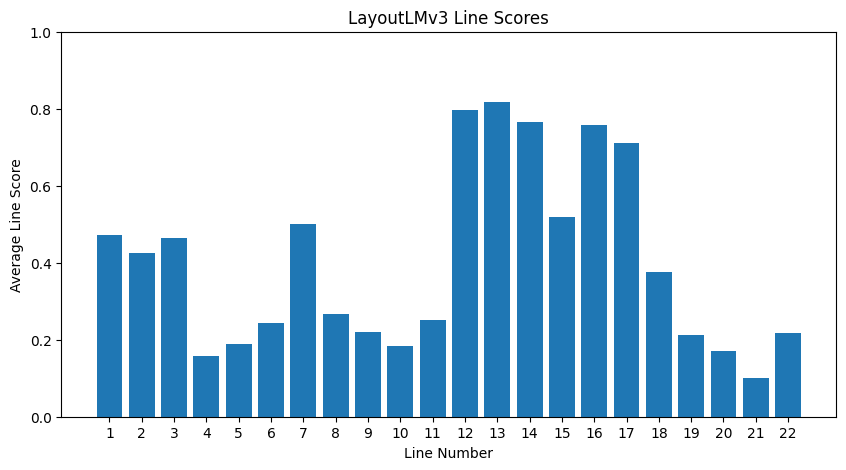

In [92]:
import matplotlib.pyplot as plt

# Assume you already ran:
# res = score_lines("rr.png")

line_ids = [r['line_id']   for r in res]
scores   = [r['line_score'] for r in res]

plt.figure(figsize=(10, 5))
plt.bar(line_ids, scores)
plt.xlabel("Line Number")
plt.ylabel("Average Line Score")
plt.title("LayoutLMv3 Line Scores")
plt.xticks(line_ids)  
plt.ylim(0, 1.0)       # scores are probabilities 0–1
plt.show()


In [94]:
threshold = 0.70
filtered = [r for r in res if r['line_score'] > threshold]

for r in filtered:
    print(f"\nLine {r['line_id']:2d} | line_score = {r['line_score']:.3f}")
    print("Text :", r['text'])
    print("Words and predictions:")
    tokens = extract_lines_with_tokens(ip)[r['line_id']-1]['tokens']
    for tok, pid, sc in zip(tokens, r['word_preds'], r['word_scores']):
        category = id2label[pid]
        print(f"  {tok['text']:<15} → {category:<20}  (score {sc:.3f})")



Line 12 | line_score = 0.798
Text : 1 Front and rear brake cables 100.00 100.00
Words and predictions:
  1               → I-sub_total.tax_price  (score 0.043)
  Front           → B-menu.cnt            (score 0.992)
  and             → B-menu.nm             (score 0.992)
  rear            → I-menu.nm             (score 0.994)
  brake           → I-menu.nm             (score 0.994)
  cables          → I-menu.nm             (score 0.994)
  100.00          → I-menu.nm             (score 0.994)
  100.00          → B-menu.unitprice      (score 0.910)

Line 13 | line_score = 0.818
Text : 2 set of pedal arms 16.00 30.00
Words and predictions:
  2               → I-sub_total.tax_price  (score 0.043)
  set             → B-menu.cnt            (score 0.992)
  of              → B-menu.nm             (score 0.992)
  pedal           → I-menu.nm             (score 0.994)
  arms            → I-menu.nm             (score 0.994)
  16.00           → I-menu.nm             (score 0.994)
  30.00           

In [100]:
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image

# ── 0) Load model & processor ──────────────────────────────────────────────
processor = LayoutLMv3Processor.from_pretrained("final_layoutlmv3_model", apply_ocr=False)
model     = LayoutLMv3ForTokenClassification.from_pretrained("final_layoutlmv3_model").eval()

# ── 1) Define footer keywords (all‐case variants) ────────────────────────────
base_footer = ["subtotal", "tax", "total", "gst", "discount", "service", "charge","sales","sales tax","cash","change","amount","sale tax","price"]
footer_keywords = set()
for w in base_footer:
    footer_keywords.update({w.lower(), w.upper(), w.capitalize()})

# ── 2) Define simplified category groups ────────────────────────────────────
category_map = {
    "QUANTITY":    ["menu.cnt", "menu.sub_cnt", "total.menuqty_cnt"],
    "UNIT_PRICE":  ["menu.unitprice", "menu.sub_unitprice"],
    "PRICE":       ["menu.price", "menu.discountprice",
                    "menu.itemsubtotal", "menu.sub_price", "void_menu.price"],
    # FOOTER types also treated as numeric for re‑scoring
    "FOOTER":      ["sub_total.discount_price", "sub_total.etc",
                    "sub_total.othersvc_price", "sub_total.service_price",
                    "sub_total.subtotal_price", "sub_total.tax_price",
                    "total.cashprice", "total.changeprice",
                    "total.creditcardprice", "total.emoneyprice",
                    "total.total_etc", "total.total_price"]
}

# ── 3) Helpers ───────────────────────────────────────────────────────────────
def is_footer_word(tok):
    return tok.lower().strip("%$") in footer_keywords

# get span of lines to weight footer probability
all_ids = [r["line_id"] for r in filtered]
min_id, max_id = min(all_ids), max(all_ids)
span = max(1, max_id - min_id)

def rescore_token(tok, line_id):
    """
    Re‑run the model on this single token, boost all FOOTER probs
    proportionally to line position (lower lines → bigger boost).
    Returns sorted label indices and their scores.
    """
    img = Image.open(ip).convert("RGB")
    W, H = img.size
    box = [int(1000 * tok[k] / (W if k in ("x","x2") else H))
           for k in ("x","y","x2","y2")]  # compute normalized box
    enc = processor(img, text=[tok["text"]], boxes=[box], return_tensors="pt")
    with torch.no_grad():
        logits = model(**{k:v for k,v in enc.items()}).logits.squeeze(0)[0]
    probs = torch.softmax(logits, dim=-1).cpu().numpy()

    # boost FOOTER-group classes
    boost = (line_id - min_id) / span
    for idx, lab in id2label.items():
        if lab in category_map["FOOTER"]:
            probs[idx] *= (1 + boost)

    return list(np.argsort(probs)[::-1]), probs

# ── 4) Build cleaned_preds ──────────────────────────────────────────────────
cleaned = []
for r in filtered:
    toks   = extract_lines_with_tokens(ip)[r["line_id"]-1]["tokens"]
    preds  = r["word_preds"]
    scores = r["word_scores"]
    new_lbls = []

    for i, (tok, pid, sc) in enumerate(zip(toks, preds, scores)):
        w = tok["text"]
        orig = id2label[pid]

        # 4a) First use model’s original prediction
        label = orig

        # 4b) If this is an alpha token predicted as numeric/price
        if w.isalpha() and label in sum((category_map[c] for c in ["QUANTITY","UNIT_PRICE","PRICE"]), []):
            # but do NOT override real descriptions (check footer first)
            if is_footer_word(w):
                label = "FOOTER_DESC"
            else:
                # re‑score to see if it should be footed
                sorted_ids, prob_vec = rescore_token(tok, r["line_id"])
                # if top FOOTER candidate prob > line_score → choose FOOTER
                for cand in sorted_ids:
                    cand_lab = id2label[cand]
                    if cand_lab in category_map["FOOTER"] and prob_vec[cand] > r["line_score"]:
                        label = "FOOTER_DESC"
                        break
                else:
                    label = "DESCRIPTION"

        # 4c) Pure alpha tokens not in numeric groups → description or footer
        elif w.isalpha():
            label = "FOOTER_DESC" if is_footer_word(w) else "DESCRIPTION"

        new_lbls.append(label)

    r["cleaned_preds"] = new_lbls
    cleaned.append(r)

# ── 5) Display final table ──────────────────────────────────────────────────
rows, foot = [], []
for r in cleaned:
    row = {"line_id": r["line_id"], "text": r["text"]}
    # bucket the tokens into the four display columns
    buckets = defaultdict(list)
    for w,l in zip(extract_lines_with_tokens(ip)[r["line_id"]-1]["tokens"], r["cleaned_preds"]):
        if l in ("QUANTITY","UNIT_PRICE","PRICE"):
            buckets[l].append(w["text"])
        elif l=="DESCRIPTION":
            buckets["DESCRIPTION"].append(w["text"])
        else:  # FOOTER_DESC or anything else
            buckets["FOOTER_DESC"].append(w["text"])
    row.update({
        "QUANTITY":    " ".join(buckets["QUANTITY"]),
        "DESCRIPTION": " ".join(buckets["DESCRIPTION"]),
        "UNIT_PRICE":  " ".join(buckets["UNIT_PRICE"]),
        "PRICE":       " ".join(buckets["PRICE"])
    })
    footer_count = sum(1 for l in r["cleaned_preds"] if l == "FOOTER_DESC")
    total_count  = len(r["cleaned_preds"])

    if footer_count / total_count >= 0.5:
        foot.append(row)
    else:
        rows.append(row)


df_main   = pd.DataFrame(rows)
df_footer = pd.DataFrame(foot)

print("🧾 Main Lines")
display(df_main)
print("\n📌 Footer Lines")
display(df_footer)


🧾 Main Lines


,line_id,text,QUANTITY,DESCRIPTION,UNIT_PRICE,PRICE
0,12,1 Front and rear brake cables 100.00 100.00,,Front and rear brake cables,,
1,13,2 set of pedal arms 16.00 30.00,,set of pedal arms,,
2,14,3 Labor 5.00 15.00,,Labor,,



📌 Footer Lines


,line_id,text,QUANTITY,DESCRIPTION,UNIT_PRICE,PRICE
0,16,Sales Tax 6.25% 9.08,,,,
1,17,TOTAL $154.06,,,,


In [102]:
import re

def is_numeric(text):
    return bool(re.match(r'^[₹$]?\d+(\.\d{1,2})?$', text.strip()))

def apply_template_if_description(tokens_with_labels):
    """
    Input: list of dicts: [{'text': ..., 'label': ..., 'score': ...}]
    Returns: corrected list of labels (same length)
    """
    tokens = [t['text'] for t in tokens_with_labels]
    old_labels = [t['label'] for t in tokens_with_labels]
    
    # Check if any word is already labeled as DESCRIPTION
    if "DESCRIPTION" not in old_labels:
        return old_labels  # skip lines like 'TOTAL $100'

    # Index all numeric tokens (excluding those already labeled DESCRIPTION)
    numeric_indices = [
        i for i, t in enumerate(tokens_with_labels)
        if is_numeric(t['text']) and old_labels[i] != "DESCRIPTION"
    ]

    # Initialize new label list with original labels
    new_labels = old_labels[:]

    # Assign PRICE to last numeric, UNIT_PRICE to second-last, QUANTITY to earliest
   # Assign PRICE
    if len(numeric_indices) >= 1:
        new_labels[numeric_indices[-1]] = "PRICE"

# Check middle value: if it's a small integer, it's likely QUANTITY not UNIT_PRICE
    if len(numeric_indices) >= 2:
        val = tokens_with_labels[numeric_indices[-2]]["text"]
        val_clean = re.sub(r'[₹$]', '', val)
        if val_clean.isdigit() and int(val_clean) <= 10:
            new_labels[numeric_indices[-2]] = "QUANTITY"
        else:
            new_labels[numeric_indices[-2]] = "UNIT_PRICE"

# Assign QUANTITY to earliest number (only if not already set)
    if len(numeric_indices) >= 3:
        if new_labels[numeric_indices[0]] not in ("QUANTITY", "PRICE"):
            new_labels[numeric_indices[0]] = "QUANTITY"

    return new_labels


In [104]:
# After your model and cleaned labels
for r in filtered:
    tokens = extract_lines_with_tokens(ip)[r['line_id'] - 1]['tokens']
    token_list = []
    for tok, label, score in zip(tokens, r["cleaned_preds"], r["word_scores"]):
        token_list.append({
            "text": tok["text"],
            "label": label,
            "score": score
        })
    
    corrected = apply_template_if_description(token_list)
    r["final_labels"] = corrected  # store it


In [106]:
from tabulate import tabulate

def print_food_format_table(filtered, img_path):
    table = []
    for r in filtered:
        tokens = extract_lines_with_tokens(img_path)[r['line_id'] - 1]['tokens']
        token_list = [
            {"text": tok["text"], "label": label}
            for tok, label in zip(tokens, r["final_labels"])
        ]

        # Group words by label
        qty         = " ".join(t["text"] for t in token_list if t["label"] == "QUANTITY")
        description = " ".join(t["text"] for t in token_list if t["label"] == "DESCRIPTION")
        unit_price  = " ".join(t["text"] for t in token_list if t["label"] == "UNIT_PRICE")
        price       = " ".join(t["text"] for t in token_list if t["label"] == "PRICE")

        table.append([r["line_id"], qty, description, unit_price, price])

    headers = ["Line", "Quantity", "Description", "Unit Price", "Price"]
    print(tabulate(table, headers=headers, tablefmt="grid"))


In [108]:
print_food_format_table(filtered, ip)


+--------+------------+-----------------------------+--------------+---------+
|   Line | Quantity   | Description                 | Unit Price   | Price   |
+========+============+=============================+==============+=========+
|     12 | 1          | Front and rear brake cables | 100.00       | 100.00  |
+--------+------------+-----------------------------+--------------+---------+
|     13 | 2          | set of pedal arms           | 16.00        | 30.00   |
+--------+------------+-----------------------------+--------------+---------+
|     14 | 3          | Labor                       | 5.00         | 15.00   |
+--------+------------+-----------------------------+--------------+---------+
|     16 |            |                             |              |         |
+--------+------------+-----------------------------+--------------+---------+
|     17 |            |                             |              |         |
+--------+------------+-----------------------------